# From Google Earth to a geological model

## Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import mplstereonet
from importlib import reload

import sys
import os
sys.path.append(r"..")  # append local path to access googlepicks module
import googlepicks

## Import, process and visualize Google Earth data

### Load .kml files

#### FW1

In [128]:
ks = []
for i, fn in enumerate(os.listdir("../data/FW1")):
    if ".kml" in fn:
        print(fn)
        ks.append(googlepicks.kml_to_plane.KmlPoints(filename="../data/FW1/"+fn, debug=True))
        print("\n")

Dips.kml
read kml
16 point sets added


Unit_1.kml
read kml
1 point sets added


Unit_2.kml
read kml
3 point sets added


Unit_3.kml
read kml
4 point sets added


Unit_4.kml
read kml
3 point sets added




In [3]:
ks_names = [s[:-4] for s in os.listdir("../data/FW1")]
ks_names

['Dips', 'Unit_1', 'Unit_2', 'Unit_3', 'Unit_4']

In [4]:
ks

#### Simple Example

### Check point sets to have at least 3 points for plane fit

In [5]:
for k in ks:
    googlepicks.check_point_sets(k)

Removed point set #1


### Load DTM to obtain elevation data and fit planes

In [6]:
# try to get elevation data from DTM geotiff
# if data points are located outside of the geotiff's extent, drop the point set
for k in ks:
    for ps in k.point_sets:
        try:
            ps.get_z_values_from_geotiff("../data/dome_sub_sub_utm.tif")
        except IndexError:
            print("Point outside geotiff, drop")
            k.point_sets.remove(ps)
            continue

        # convert LatLon coordinates to UTM
        ps.latlong_to_utm()
        # Fit plane to point set
        ps.plane_fit()

### Visualize points in 3D

* [TODO] Make 3d point plot nicer (color for units)

In [7]:
ks_coords = []
for k in ks:
    ks_coords.append(googlepicks.extract_xyz(k))

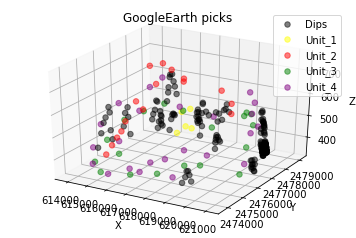

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

colors = ["black", "yellow", "red", "green", "purple"]

for i, k in enumerate(ks_coords):
    ax.scatter(k[0],k[1],k[2], c=colors[i], alpha=0.5, s=30, label=ks_names[i])

ax.legend()
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("GoogleEarth picks")

### Determine dip angles and dip diretions

In [9]:
# create storage lists
dips = []
dip_dirs = []
dip_xs = []
dip_ys = []
dip_zs = []

# loop over all point sets, determine dip angle and dip direction and append them to storage lists
for k in ks:
    for ps in k.point_sets:
        
        # determine dip angle from normal vector of plane
        dips.append(googlepicks.dip(ps.normal)) 
        # get dip direction from normal vector
        dip_dirs.append(googlepicks.dip_dir(ps.normal))
        # get centroid coordinates
        dip_xs.append(ps.ctr.x)
        dip_ys.append(ps.ctr.y)
        dip_zs.append(ps.ctr.z)

Plot histograms of the extracted dip and dip direction data:

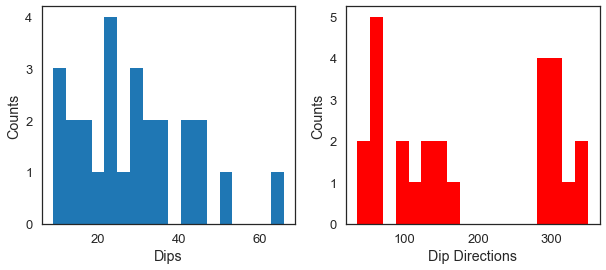

In [18]:
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.hist(dips, 18)
ax1.set_xlabel("Dips")
ax1.set_ylabel("Counts")
ax2.hist(dip_dirs, 18, color='r');
ax2.set_xlabel("Dip Directions")
ax2.set_ylabel("Counts");

### Stereonet Plots

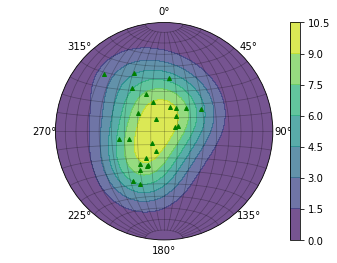

In [11]:
fig, ax = mplstereonet.subplots()
cax = ax.density_contourf(dip_dirs, dips, measurement='poles', cmap='viridis', alpha=0.75)
fig.colorbar(cax)
ax.pole(dip_dirs, dips, 'g^', markersize=4)
ax.grid(True, color="black", alpha=0.25)

plt.show()

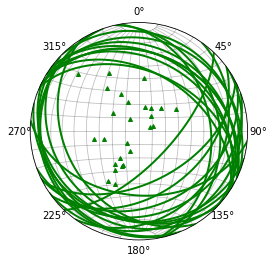

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='stereonet')
ax.pole(dip_dirs, dips, 'g^', markersize=4)
ax.plane(dip_dirs, dips, 'g-', linewidth=2)
ax.grid(True, color="black", alpha=0.25)

# To GemPy dataframe

## Interfaces

In [13]:
interf = googlepicks.points_to_gempy_interf(ks_coords[1:], ks_names[1:])

## Foliations

In [14]:
fols = googlepicks.dips_to_gempy_fol(dips, dip_dirs, dip_xs, dip_ys, dip_zs, "Unit_2")

## Save to .csv files

In [21]:
interf.to_csv("gempy_interfaces.csv", index=False)
fols.to_csv("gempy_foliations.csv", index=False)

# GemPy

In [22]:
# These two lines are necessary only if gempy is not installed
sys.path.append("../../gempy/")

# Importing gempy
import gempy as gp


In [47]:
geo_data=gp.create_data(extent=[612000, 622000, 2472000, 2480000, -1000, 1000], 
                        path_f = "gempy_foliations.csv",
                        path_i = "gempy_interfaces.csv")

C:\ProgramData\Anaconda3\envs\googlepicks\lib\site-packages\gempy\DataManagement.py:421: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  self.interfaces["series"] = [(i == _series).sum().argmax() for i in self.interfaces["formation"]]
C:\ProgramData\Anaconda3\envs\googlepicks\lib\site-packages\gempy\DataManagement.py:424: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  self.foliations["series"] = [(i == _series).sum().argmax() for i in self.foliations["formation"]]


C:\ProgramData\Anaconda3\envs\googlepicks\lib\site-packages\gempy\DataManagement.py:421: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  self.interfaces["series"] = [(i == _series).sum().argmax() for i in self.interfaces["formation"]]
C:\ProgramData\Anaconda3\envs\googlepicks\lib\site-packages\gempy\DataManagement.py:424: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  self.foliations["series"] = [(i == _series).sum().argmax() for i in self.foliations["formation"]]


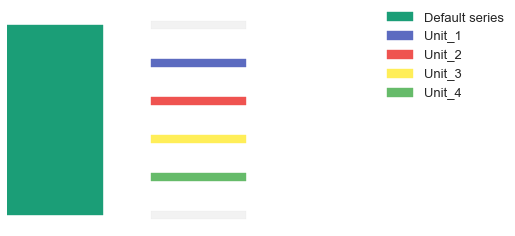

In [48]:
gp.set_series(geo_data, {"Default series": ("Unit_1", "Unit_2", "Unit_3", "Unit_4")},
             order_formations = ["Unit_1", "Unit_2", "Unit_3", "Unit_4"])

## Data visualization

### 2D

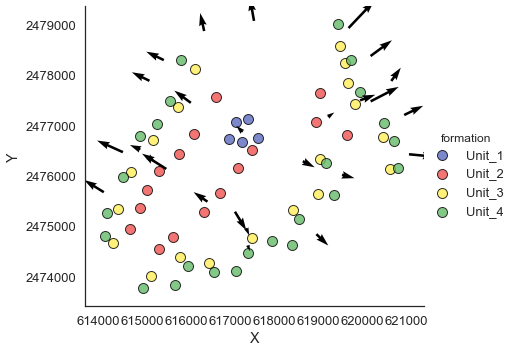

In [49]:
gp.plot_data(geo_data, direction="z")

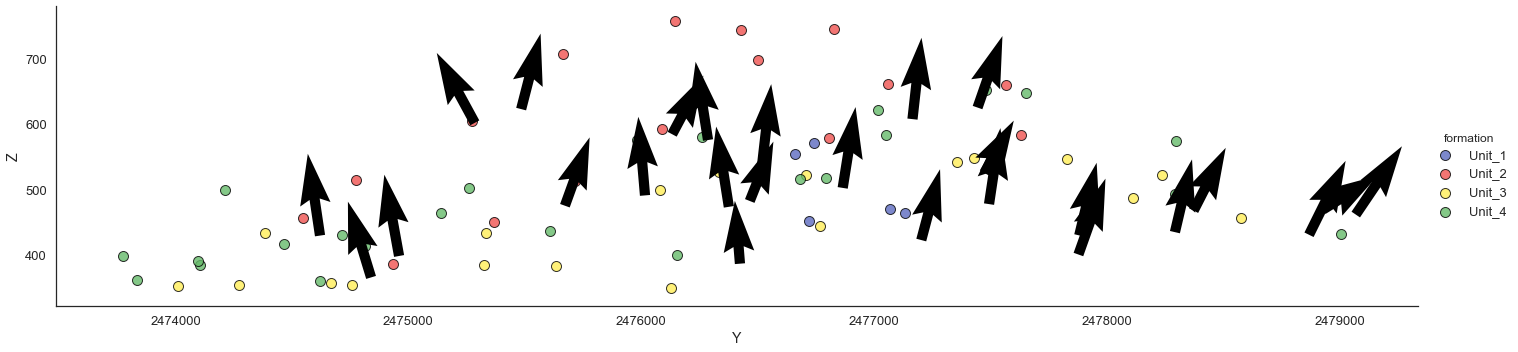

In [56]:
gp.plot_data(geo_data, direction="x")

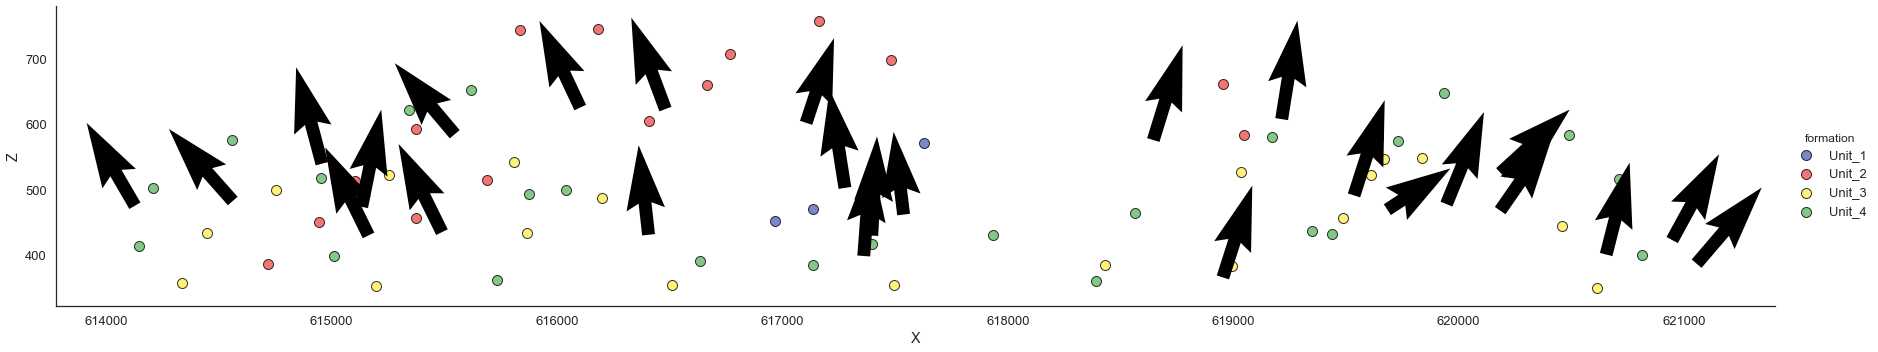

In [58]:
gp.plot_data(geo_data, direction="y")

### 3D

In [50]:
gp.plot_data_3D(geo_data)

## Computing the 3D model

Instantiate interpolator

In [51]:
interp_data = gp.InterpolatorInput(geo_data)

Level of Optimization:  fast_compile
Device:  cpu
Precision:  float32


Compute

In [52]:
lith_block, fault_block = gp.compute_model(interp_data)

## Model visualization

### 2D Sections

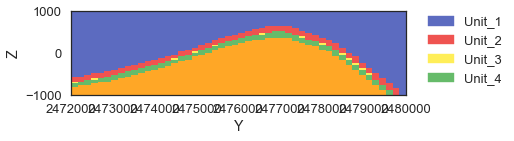

In [53]:
gp.plot_section(geo_data, lith_block[0], 40, direction='x')

### 3D Surfaces

In [127]:
v_l, s_l = gp.get_surfaces(interp_data, potential_lith=lith_block[1])
gp.plot_surfaces_3D(geo_data, v_l, s_l)

### Pseudo-3D point clouds

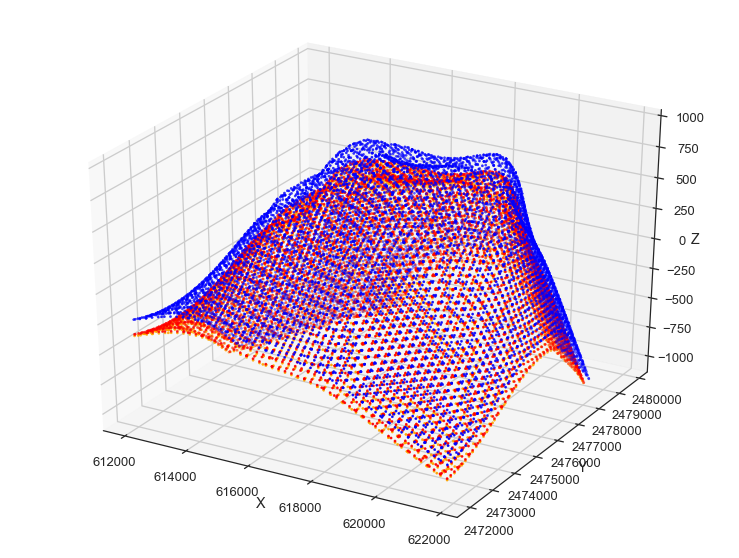

In [55]:
%matplotlib inline
fig = plt.figure(figsize=(13,10))
ax = fig.add_subplot(111, projection='3d')

cs = ["blue", "red", "orange"]
for i in range(3):
    ax.scatter(v_l[i][:,0],v_l[i][:,1],v_l[i][:,2], c=cs[i], s=5)
    
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

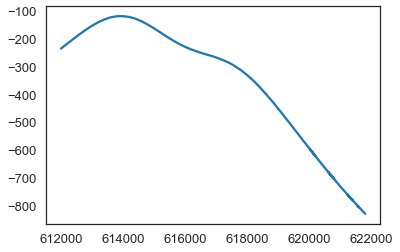

In [124]:
plt.plot(v_l[0][:,0][v_l[0][:,1]==np.min(v_l[0][:,1])], v_l[0][:,2][v_l[0][:,1]==np.min(v_l[0][:,1])])